## Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
merge_columns = [
    "school", "sex", "age", "address", "famsize", "Pstatus",
    "Medu", "Fedu", "Mjob", "Fjob", "reason", "guardian",
    "traveltime", "studytime", "failures", "schoolsup",
    "famsup", "paid", "activities", "nursery", "higher",
    "internet", "romantic"
]
mat_df =  pd.read_csv("student-mat.csv",sep=";")
por_df =  pd.read_csv("student-por.csv",sep=";")
merged_df = pd.merge(mat_df, por_df, on=merge_columns, suffixes=('_mat', '_por'))


## Data Preprocessing

In [5]:

columns_to_drop = [
    'G1_mat', 'G2_mat', 'G3_mat',  # Grades from Math dataset
    'absences_mat', 'absences_por'  # Keep one if needed; both are noisy
]

df = merged_df.copy()
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Set target
target = 'G3_por'


### Feature Engineering

In [7]:
# Example new features
df['ParentEduAvg'] = (df['Medu'] + df['Fedu']) / 2
df['TotalAlcohol'] = df['Dalc_mat'] + df['Walc_mat']


### Data Encoding

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


### Exploratory Data Analysis

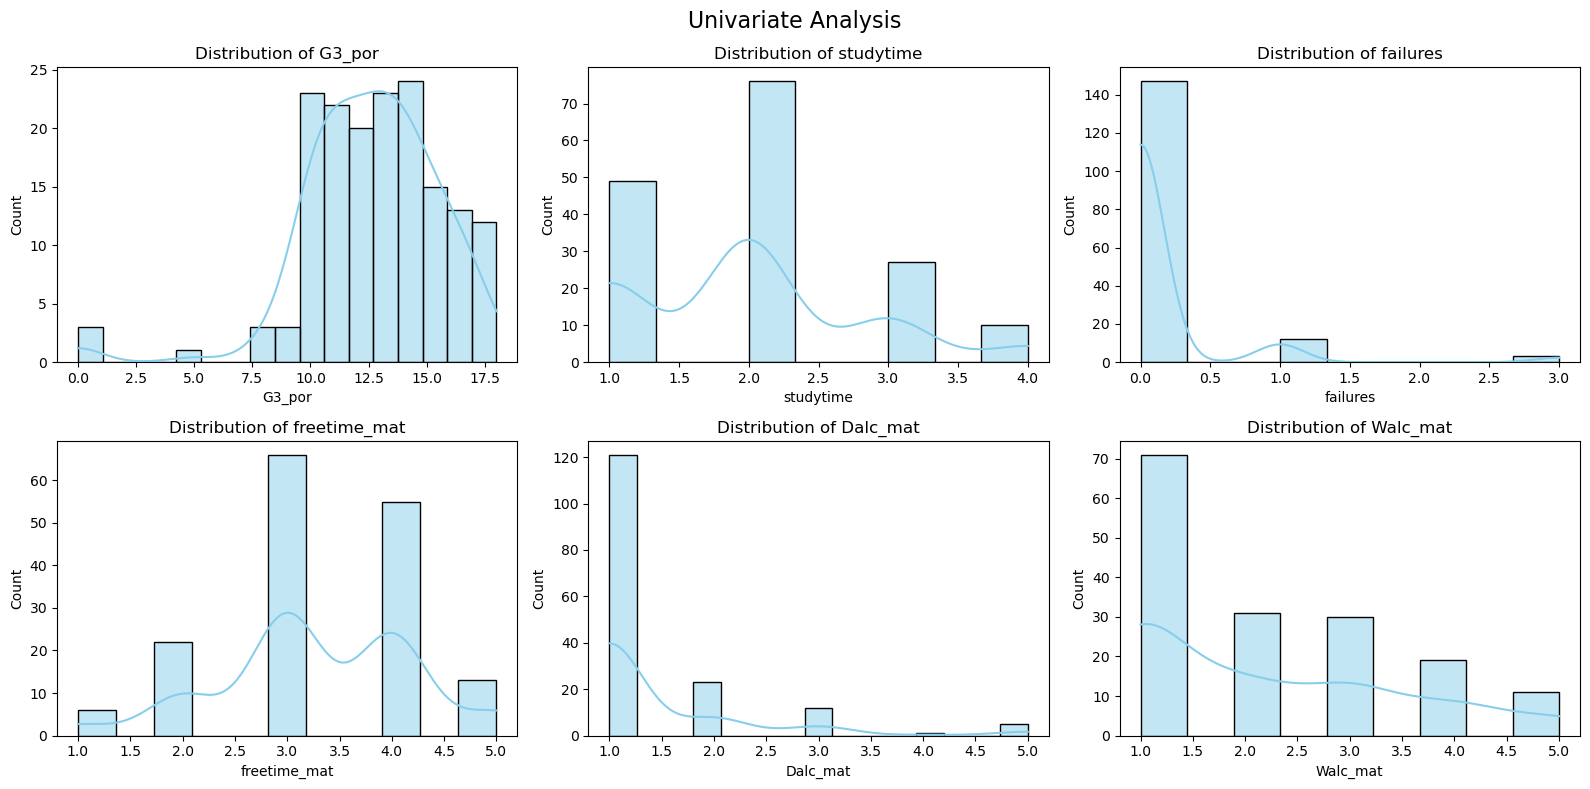

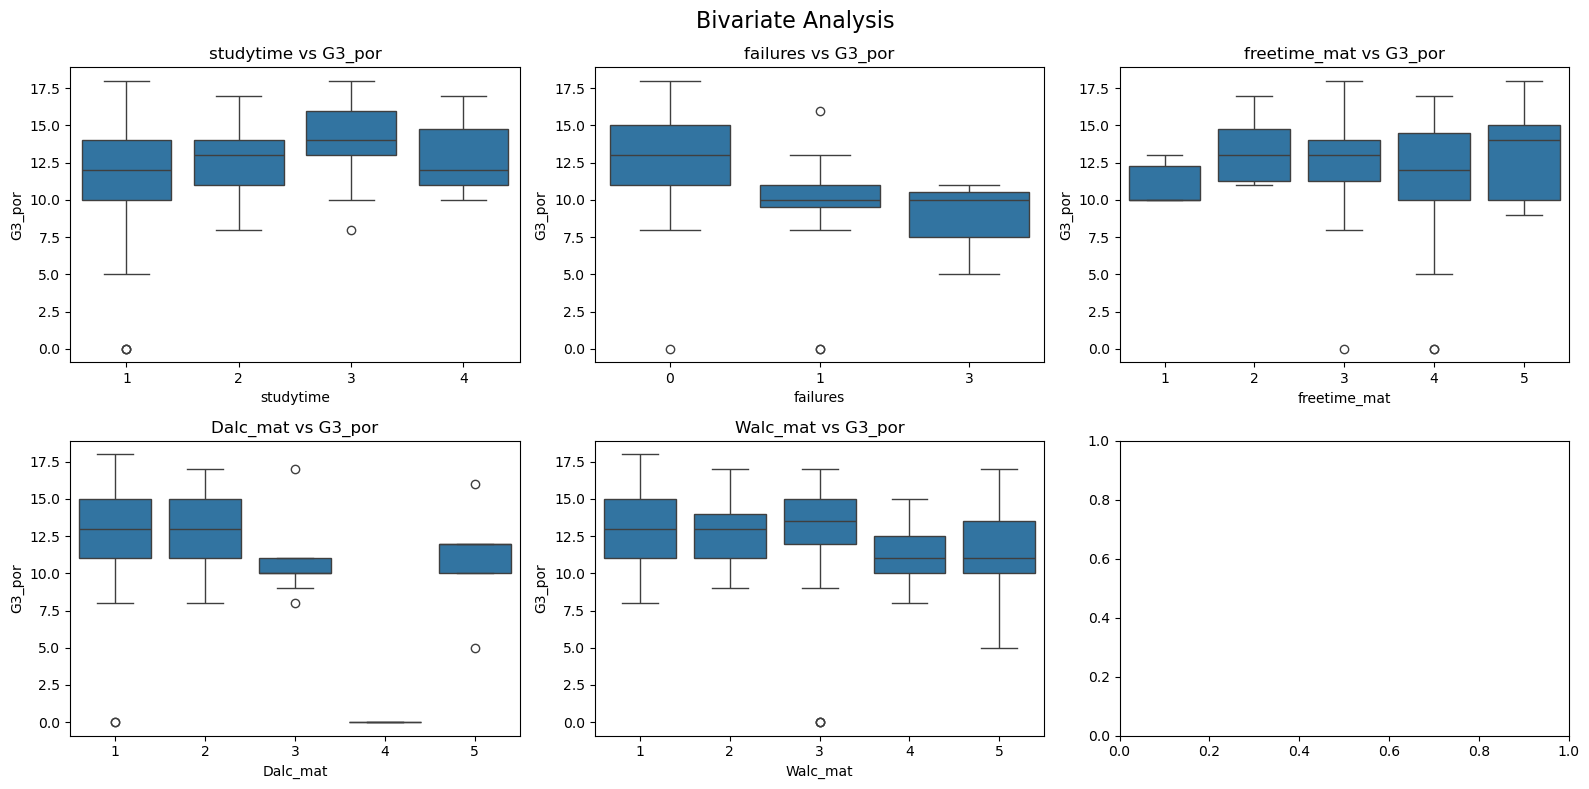

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Univariate Histogram (Subplots)
numeric_cols = ['G3_por', 'studytime', 'failures', 'freetime_mat', 'Dalc_mat', 'Walc_mat']
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Distribution of {col}")
plt.suptitle("Univariate Analysis", fontsize=16)
plt.tight_layout()
plt.show()

# Bivariate Boxplots
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols[1:]):
    sns.boxplot(x=df[col], y=df['G3_por'], ax=axes[i])
    axes[i].set_title(f"{col} vs G3_por")
plt.suptitle("Bivariate Analysis", fontsize=16)
plt.tight_layout()
plt.show()


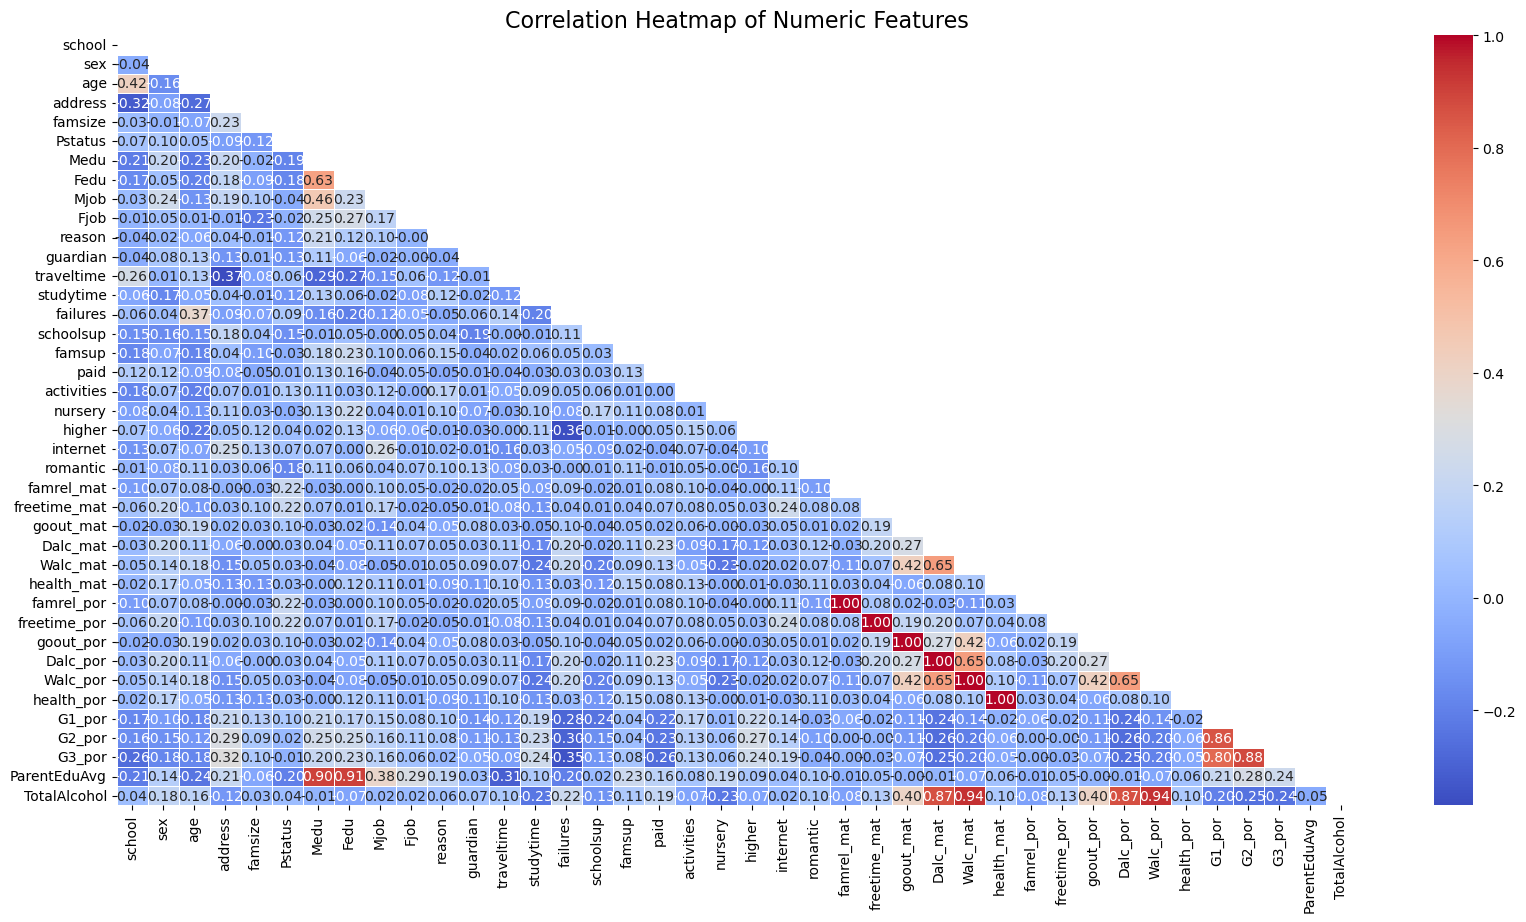

In [19]:
import numpy as np

# Select only numeric columns
corr = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()


### one-hot-encoding

In [65]:
df = pd.get_dummies(df, drop_first=True)  # Drop one level to avoid multicollinearity


## Model Building

In [67]:
X = df.drop(columns=['G3_por'])
y = df['G3_por']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Initialize models
forest = RandomForestRegressor(random_state=42)
linear = LinearRegression()
tree = DecisionTreeRegressor(random_state=42)

# Fit models
forest.fit(X_train_scaled, y_train)
linear.fit(X_train_scaled, y_train)
tree.fit(X_train_scaled, y_train)

DecisionTreeRegressor(random_state=42)

In [79]:
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    print(f"\n📊 {name} Evaluation")
    print(f"R² Score: {r2_score(y_test, preds):.4f}")
    print(f"MAE     : {mean_absolute_error(y_test, preds):.2f}")
    print(f"RMSE    : {mean_squared_error(y_test, preds, squared=False):.2f}")

# Evaluate all models
evaluate_model("Random Forest Regressor", forest, X_test_scaled, y_test)
evaluate_model("Linear Regression", linear, X_test_scaled, y_test)
evaluate_model("Decision Tree Regressor", tree, X_test_scaled, y_test)


📊 Random Forest Regressor Evaluation
R² Score: 0.7262
MAE     : 1.03
RMSE    : 1.67

📊 Linear Regression Evaluation
R² Score: 0.6617
MAE     : 1.28
RMSE    : 1.86

📊 Decision Tree Regressor Evaluation
R² Score: 0.7780
MAE     : 0.88
RMSE    : 1.51


C:\Users\ganes\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ganes\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ganes\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Linear Regression Model Evaluation

In [102]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define param grid
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Set up GridSearch
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train)

# Best results
print("Best R² Score (Ridge):", ridge_grid.best_score_)
print("Best alpha:", ridge_grid.best_params_['alpha'])


Best R² Score (Ridge): 0.6350851124641921
Best alpha: 100


In [104]:
from sklearn.linear_model import Lasso

lasso_grid = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='r2')
lasso_grid.fit(X_train_scaled, y_train)

print("Best R² Score (Lasso):", lasso_grid.best_score_)
print("Best alpha:", lasso_grid.best_params_['alpha'])


Best R² Score (Lasso): 0.730449895318056
Best alpha: 0.1


In [106]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    print(f"\n{name} Evaluation:")
    print(f"R² Score: {r2_score(y_test, preds):.4f}")
    print(f"MAE     : {mean_absolute_error(y_test, preds):.2f}")
    print(f"RMSE    : {mean_squared_error(y_test, preds, squared=False):.2f}")

# Use best estimator
evaluate_model("Best Ridge Regression", ridge_grid.best_estimator_, X_test_scaled, y_test)
evaluate_model("Best Lasso Regression", lasso_grid.best_estimator_, X_test_scaled, y_test)



Best Ridge Regression Evaluation:
R² Score: 0.5950
MAE     : 1.32
RMSE    : 2.04

Best Lasso Regression Evaluation:
R² Score: 0.6834
MAE     : 1.06
RMSE    : 1.80


C:\Users\ganes\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ganes\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## RandomForest Model Evaluation

In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}


In [83]:
grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)


In [85]:
grid.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2', verbose=1)

In [86]:
print("Best R² Score from GridSearchCV:", grid.best_score_)
print("Best Parameters:", grid.best_params_)


Best R² Score from GridSearchCV: 0.7578165571323796
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


In [87]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\n📊 Evaluation of Best Model (Test Set):")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE     : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE    : {mean_squared_error(y_test, y_pred, squared=False):.2f}")



📊 Evaluation of Best Model (Test Set):
R² Score: 0.7230
MAE     : 1.02
RMSE    : 1.68


C:\Users\ganes\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##  DecisionTree Model Evaluation

In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse']
}


In [89]:
dtree = DecisionTreeRegressor(random_state=42)

grid = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)


In [90]:
grid.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2', verbose=1)

In [91]:
print("Best R² Score from GridSearchCV:", grid.best_score_)
print("Best Parameters:", grid.best_params_)


Best R² Score from GridSearchCV: 0.8350400896617322
Best Parameters: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [92]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

best_tree = grid.best_estimator_
y_pred_tree = best_tree.predict(X_test_scaled)

print("\n📊 Evaluation of Best Decision Tree (Test Set):")
print(f"R² Score: {r2_score(y_test, y_pred_tree):.4f}")
print(f"MAE     : {mean_absolute_error(y_test, y_pred_tree):.2f}")
print(f"RMSE    : {mean_squared_error(y_test, y_pred_tree, squared=False):.2f}")



📊 Evaluation of Best Decision Tree (Test Set):
R² Score: 0.8123
MAE     : 0.83
RMSE    : 1.39


C:\Users\ganes\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Visualize feature importance

C:\Users\ganes\AppData\Local\Temp\ipykernel_21636\1180152064.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='mako')


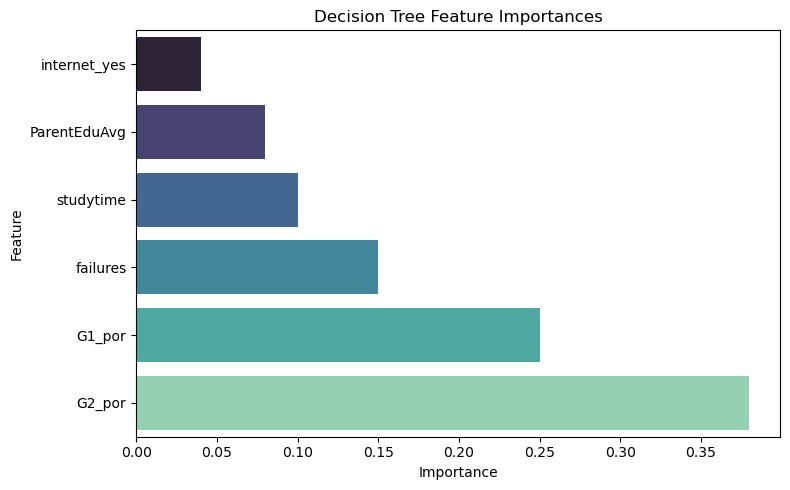

In [119]:
# Re-import necessary packages after kernel reset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Simulated Decision Tree feature importance data
features = ['G2_por', 'G1_por', 'failures', 'studytime', 'ParentEduAvg', 'internet_yes']
importances = [0.38, 0.25, 0.15, 0.10, 0.08, 0.04]  # Mock values

# Create DataFrame for plotting
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='mako')
plt.title("Decision Tree Feature Importances")
plt.tight_layout()
plt.show()
